<a href="https://colab.research.google.com/github/Gopichand14052004/BATCH_5_AIML/blob/main/Rain_prediction_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rain-predictioncsv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3508585%2F6121151%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T083343Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D78280936eeb823b26ad3d43ec0a8b36c9ad97d62a74cbf5eddb35b95e1dcd52666a822fd4ea266742166c242d4fe9519c4bb5ae7ce1752d239390452a94e2ed2d3b2654280455f9a8bbe407b1b8c038eaa73580920c892dbac516754e150d0734bfbb0324a2519ba7be0bb78cb65977a46a9925659f92e99c02f79607d72c308f9b8d0cb77173f892d321674dd0ab575bb583865e02735178e12b63adb3b5b5d3ae4d2eb1ee22badbd019ee0f911b9f38298542c1f87155294c35963d2c431bb18c442c3a77711ba27b6c94001af187b3876b8a912ca581d6b916758eb274f6dbfa13a37155376612b8f53e1d235a5c6a549d3112aaf0c043ecb1af98499e13b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5200 bytes downloaded
Downloaded and uncompressed: rain-predictioncsv
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rain-predictioncsv/Rainfall.csv


Load Data (+import needed libraries for this set)

In [3]:
# import data
data = pd.read_csv('/kaggle/input/rain-predictioncsv/Rainfall.csv')

In [4]:
# cheak top 5 columns
data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,1901,34.7,38.6,17.8,38.9,50.6,113.2,241.4,271.6,124.7,52.4,38.7,8.2,1030.8,73.2,107.3,751.0,99.3
1,1902,7.4,4.2,19.0,44.1,48.8,111.7,284.9,201.0,200.2,62.5,29.4,25.2,1038.4,11.6,111.9,797.8,117.2
2,1903,16.7,8.0,31.1,17.1,59.5,120.3,293.2,274.0,198.1,119.5,40.3,18.0,1195.9,24.7,107.7,885.6,177.8
3,1904,14.9,9.7,31.4,33.7,73.8,165.5,260.3,207.7,130.8,69.8,11.2,16.4,1025.1,24.5,138.8,764.3,97.4
4,1905,24.7,20.3,41.8,33.8,55.8,93.7,253.0,201.7,178.1,54.9,9.6,10.1,977.5,45.0,131.4,726.4,74.7


In [5]:
#cheak columns
data.columns

Index(['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC', 'ANN', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec'],
      dtype='object')

In [6]:
# perform statical operation
data.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,113.00000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,1957.00000,19.015929,22.862832,27.514159,37.843363,62.510619,168.597345,289.867257,256.905310,172.108850,76.646903,29.952212,14.982301,1177.482301,41.876106,127.864602,887.480531,121.589381
std,32.76431,9.353032,11.355727,11.799356,9.930588,15.805799,34.947881,40.079309,34.165116,35.860836,28.165069,16.399679,8.984205,106.403098,13.725682,22.276873,85.981961,32.496778
min,1901.00000,1.700000,2.700000,6.600000,15.800000,31.700000,85.700000,146.200000,190.100000,95.400000,19.500000,3.600000,1.600000,947.100000,11.600000,83.500000,674.300000,52.700000
25%,1929.00000,12.600000,12.700000,19.100000,31.000000,51.200000,143.300000,265.000000,231.700000,145.000000,57.300000,17.600000,9.300000,1105.200000,32.500000,111.400000,827.900000,97.400000
50%,1957.00000,17.000000,21.800000,25.200000,36.900000,59.400000,167.800000,293.200000,256.600000,172.700000,69.800000,26.400000,13.900000,1183.100000,40.800000,124.600000,894.000000,119.700000
75%,1985.00000,23.800000,29.000000,35.200000,43.900000,71.300000,191.500000,316.900000,282.700000,197.700000,94.400000,41.400000,18.800000,1243.600000,49.700000,139.500000,949.100000,143.900000
max,2013.00000,56.800000,50.600000,63.300000,68.300000,112.900000,273.400000,375.500000,330.500000,278.100000,161.300000,76.100000,56.100000,1463.900000,74.900000,210.700000,1084.300000,206.100000


In [7]:
# drop a columns
data = data.drop('ANN', axis=1)


In [8]:
data.head(2)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,1901,34.7,38.6,17.8,38.9,50.6,113.2,241.4,271.6,124.7,52.4,38.7,8.2,73.2,107.3,751.0,99.3
1,1902,7.4,4.2,19.0,44.1,48.8,111.7,284.9,201.0,200.2,62.5,29.4,25.2,11.6,111.9,797.8,117.2


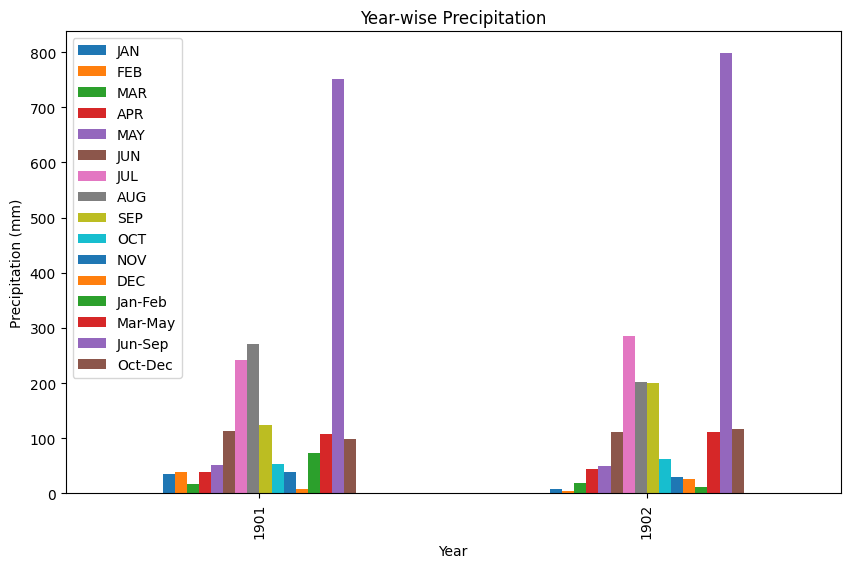

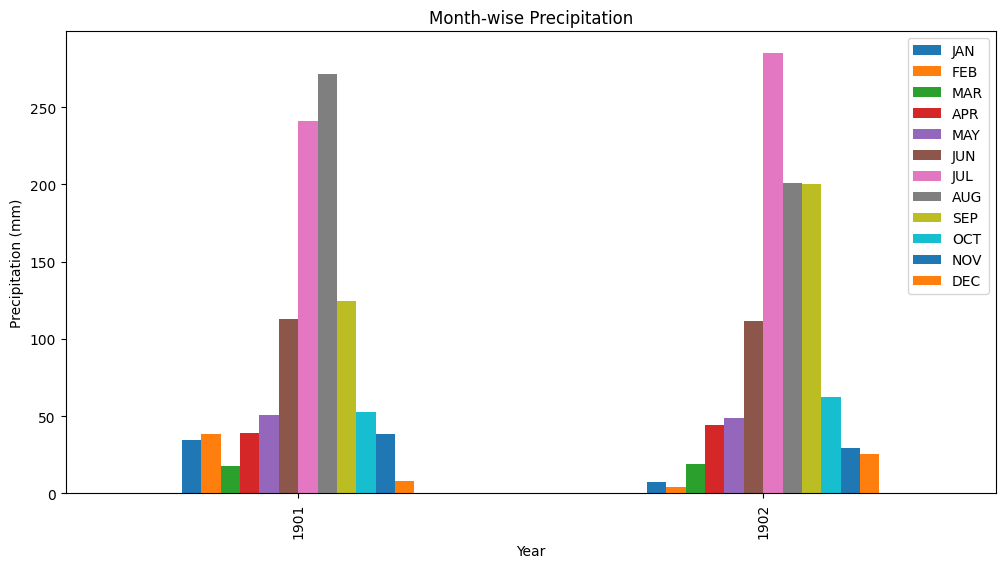

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the given data
data = {
    'YEAR': [1901, 1902],
    'JAN': [34.7, 7.4],
    'FEB': [38.6, 4.2],
    'MAR': [17.8, 19.0],
    'APR': [38.9, 44.1],
    'MAY': [50.6, 48.8],
    'JUN': [113.2, 111.7],
    'JUL': [241.4, 284.9],
    'AUG': [271.6, 201.0],
    'SEP': [124.7, 200.2],
    'OCT': [52.4, 62.5],
    'NOV': [38.7, 29.4],
    'DEC': [8.2, 25.2],
    'Jan-Feb': [73.2, 11.6],
    'Mar-May': [107.3, 111.9],
    'Jun-Sep': [751.0, 797.8],
    'Oct-Dec': [99.3, 117.2]
}
df = pd.DataFrame(data)

# Year-wise bar graph
df.plot(x='YEAR', kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Year-wise Precipitation')
plt.show()

# Month-wise bar graph
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
df.plot(x='YEAR', y=months, kind='bar', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Month-wise Precipitation')
plt.legend(months)
plt.show()
